# Active Learning

### Hyperparams

In [1]:
TRAIN_VAL_SPLIT = 0.1
BATCH_SIZE = 32

EPOCHS_BASELINE = 3

EPOCHS_AL = 1
AL_SAMPLE_SIZE = 500
AL_ITERATIONS = 10
SAMPLING_METHOD = 3

### Imports

In [2]:
# General
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import math
from scipy.stats import entropy

import tensorflow as tf

# CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# TensorBoard
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

## Baseline CNN Method

### Full dataset

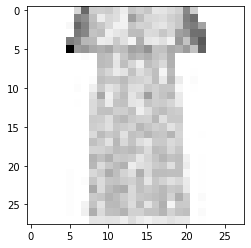

(60000, 28, 28)

In [3]:
(X_train_baseline, y_train_baseline), (X_test_baseline, y_test_baseline) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train_baseline = tf.keras.utils.normalize(X_train_baseline, axis=1)
X_test_baseline = tf.keras.utils.normalize(X_test_baseline, axis=1)

plt.imshow(X_train_baseline[np.random.randint(0, X_train_baseline.shape[0])], cmap=plt.cm.binary)
plt.show()

X_train_baseline.shape

### CNN model

In [4]:
no_channels = 1
input_shape = (X_train_baseline.shape[1], X_train_baseline.shape[2], no_channels)

# sequential apif
# convolutional layers: specify no. conv filters (to give certain output shape), kernel dimensions
baseline_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation="relu"),

    Dense(10, activation="softmax")
])

# compile model
baseline_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model
baseline_history = baseline_model.fit(X_train_baseline, y_train_baseline, epochs=EPOCHS_BASELINE, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

Epoch 1/3
1688/1688 [==============================] - 8s 4ms/step - loss: 0.4909 - accuracy: 0.8192 - val_loss: 0.3589 - val_accuracy: 0.8678
Epoch 2/3
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3285 - accuracy: 0.8781 - val_loss: 0.3080 - val_accuracy: 0.8847
Epoch 3/3
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2842 - accuracy: 0.8939 - val_loss: 0.2756 - val_accuracy: 0.8968


313/313 [==============================] - 1s 3ms/step - loss: 0.2940 - accuracy: 0.8907
loss = 0.29400143027305603
accuracy = 0.8906999826431274


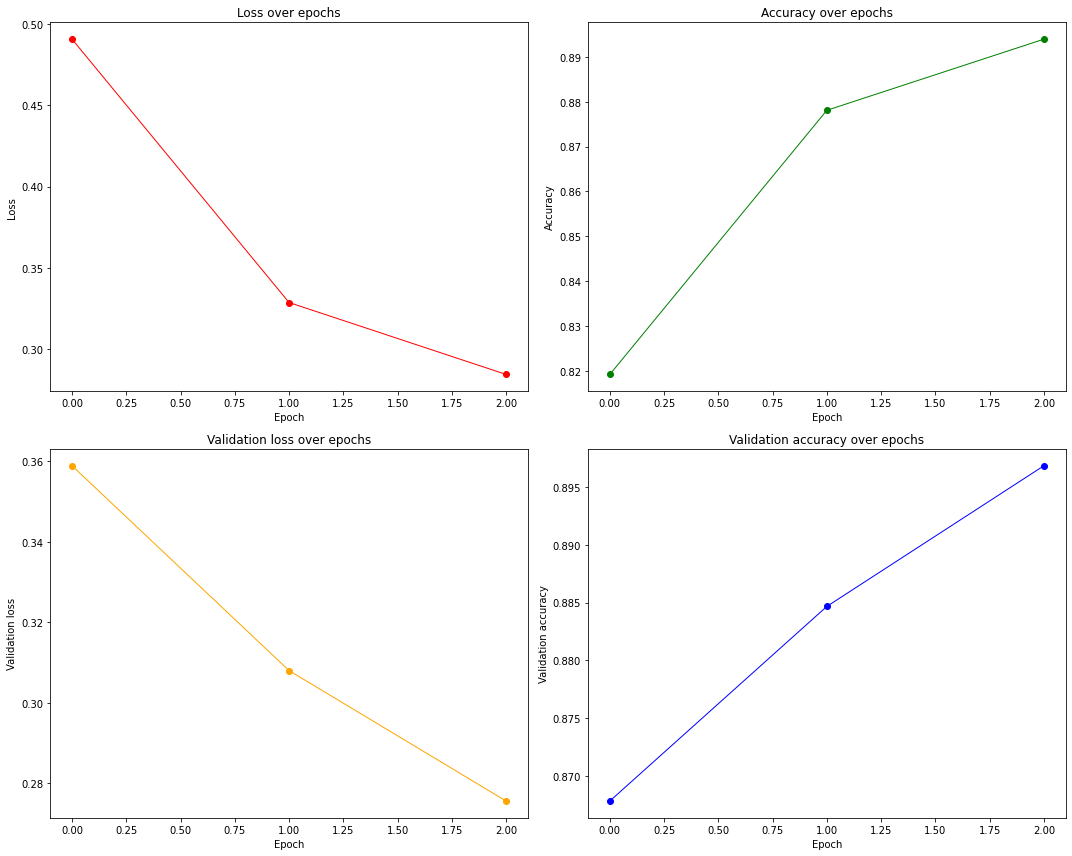

In [5]:
test_loss_baseline, test_acc_baseline = baseline_model.evaluate(X_test_baseline, y_test_baseline)
print(f"loss = {test_loss_baseline}")
print(f"accuracy = {test_acc_baseline}")

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

baseline_loss = baseline_history.history['loss']
ax[0, 0].plot(baseline_loss, linewidth=1.0, color='red', marker='o')
ax[0, 0].set(title=f'Loss over epochs', xlabel='Epoch', ylabel='Loss')

baseline_accuracy = baseline_history.history['accuracy']
ax[0, 1].plot(baseline_accuracy, linewidth=1.0, color='green', marker='o')
ax[0, 1].set(title=f'Accuracy over epochs', xlabel='Epoch', ylabel='Accuracy')

baseline_valloss = baseline_history.history['val_loss']
ax[1, 0].plot(baseline_valloss, linewidth=1.0, color='orange', marker='o')
ax[1, 0].set(title=f'Validation loss over epochs', xlabel='Epoch', ylabel='Validation loss')

baseline_valacc = baseline_history.history['val_accuracy']
ax[1, 1].plot(baseline_valacc, linewidth=1.0, color='blue', marker='o')
ax[1, 1].set(title=f'Validation accuracy over epochs', xlabel='Epoch', ylabel='Validation accuracy')
    
plt.tight_layout()
plt.show()

## Active learning process

1. Gather full dataset.
2. Split full dataset into *training* and *testing* datasets.
3. Split training dataset into labelled *pool* (initially the *seed*) and unlabelled *validation* sets.
4. Initially train model over *seed*.
5. Use model to generate prediction probabilities over validation set.
6. Evaluate importance function over instances in the validation set.
7. Select the top $k$ most important instances, label, and move to the pool dataset.
8. Renormalise pool and retrain model.
9. Repeat for until max. epochs or accuracy goal is met.
10. Test final model on testing dataset.

### Dataset splitting

In [6]:
# 1. pull full dataset and 2. conduct train-test split
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# normalise datasets
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

# 3. split into seed pool and validation sets
k = AL_SAMPLE_SIZE
print(f"sample size = {k}")

X_pool = X_train[:k]
y_pool = y_train[:k]
X_val = X_train[k:]
y_val = y_train[k:]

sample size = 500


### Model to be trained

In [7]:
no_channels = 1
input_shape = (X_train.shape[1], X_train.shape[2], no_channels)

al_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation="relu"),

    Dense(10, activation="softmax")
])

al_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 4. initially train model over seed pool
print("Initial seed training")
print(f"Pool set: {X_pool.shape[0]}; Validation set:\n   X: {X_val.shape[0]}\n")

history = al_model.fit(X_pool, y_pool, epochs=EPOCHS_AL, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

Initial seed training
Pool set: 500; Validation set:
   X: 59500

15/15 [==============================] - 1s 23ms/step - loss: 2.1766 - accuracy: 0.2556 - val_loss: 1.8684 - val_accuracy: 0.4200


In [8]:
pool_sizes = []
pool_sizes.append(X_pool.shape[0])

losses = []
losses.extend(history.history['loss'])

accuracies = []
accuracies.extend(history.history['accuracy'])

losses_val = []
losses_val.extend(history.history['val_loss'])

accuracies_val = []
accuracies_val.extend(history.history['val_accuracy'])

### Training loop, computing importance scores and building pool

In [9]:
for it in range(AL_ITERATIONS):
    # 5. generate prediction probabiltiies of validation set
    val_probs = al_model.predict(X_val)

    if SAMPLING_METHOD == 1:
        # 6. uncertainty sampling
        importance_scores = np.max(val_probs, axis=1)

        # 7. select k most important instances as those with the smallest prediction probability
        important_indices = np.argpartition(importance_scores, k)[:k]

    elif SAMPLING_METHOD == 2:
        # 6. entropy sampling
        importance_scores = entropy(val_probs, axis=1)

        # 7. select k most important instances as those with the largest entropy
        important_indices = np.argpartition(importance_scores, -k)[-k:]

    elif SAMPLING_METHOD == 3:
        # 6. margin sampling
        highest_two_probs = np.partition(val_probs, -2, axis=1)[:, -2:]
        importance_scores = np.diff(highest_two_probs, axis=1)
        importance_scores = np.squeeze(importance_scores, axis=1)

        # 7. select k most important instances as those with the smallest margin
        important_indices = np.argpartition(importance_scores, k)[:k]


    # update pool
    X_pool = np.append(X_pool, X_val[important_indices], axis=0)
    y_pool = np.append(y_pool, y_val[important_indices], axis=0)

    # update validation set
    val_indices = [i for i in range(0, X_val.shape[0]) if i not in important_indices]
    X_val = X_val[val_indices]
    y_val = y_val[val_indices]

    # 8. renormalise and retrain model over new pool
    X_pool = tf.keras.utils.normalize(X_pool, axis=1)
    X_val = tf.keras.utils.normalize(X_val, axis=1)

    print(f"\nIteration {it}")
    history = al_model.fit(X_pool, y_pool, epochs=EPOCHS_AL, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)

    print(f"Pool set: {X_pool.shape[0]}; Validation set: {X_val.shape[0]}")

    # save metrics from this iteration
    pool_sizes.append(X_pool.shape[0])
    losses.extend(history.history['loss'])
    accuracies.extend(history.history['accuracy'])
    losses_val.extend(history.history['val_loss'])
    accuracies_val.extend(history.history['val_accuracy'])


Iteration 0
29/29 [==============================] - 0s 8ms/step - loss: 1.5095 - accuracy: 0.4378 - val_loss: 1.4048 - val_accuracy: 0.4700
Pool set: 1000; Validation set: 59000

Iteration 1
43/43 [==============================] - 0s 8ms/step - loss: 1.0810 - accuracy: 0.5815 - val_loss: 1.0881 - val_accuracy: 0.5933
Pool set: 1500; Validation set: 58500

Iteration 2
57/57 [==============================] - 0s 6ms/step - loss: 0.9587 - accuracy: 0.6167 - val_loss: 1.0894 - val_accuracy: 0.5750
Pool set: 2000; Validation set: 58000

Iteration 3
71/71 [==============================] - 0s 6ms/step - loss: 0.9264 - accuracy: 0.6244 - val_loss: 1.1662 - val_accuracy: 0.5040
Pool set: 2500; Validation set: 57500

Iteration 4
85/85 [==============================] - 0s 5ms/step - loss: 0.8652 - accuracy: 0.6574 - val_loss: 1.0826 - val_accuracy: 0.4867
Pool set: 3000; Validation set: 57000

Iteration 5
99/99 [==============================] - 1s 5ms/step - loss: 0.8167 - accuracy: 0.6781 

In [10]:
test_loss_al, test_acc_al = al_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"loss = {test_loss_al}")
print(f"accuracy = {test_acc_al}")

313/313 [==============================] - 1s 2ms/step - loss: 0.4643 - accuracy: 0.8360
loss = 0.464311420917511
accuracy = 0.8360000252723694


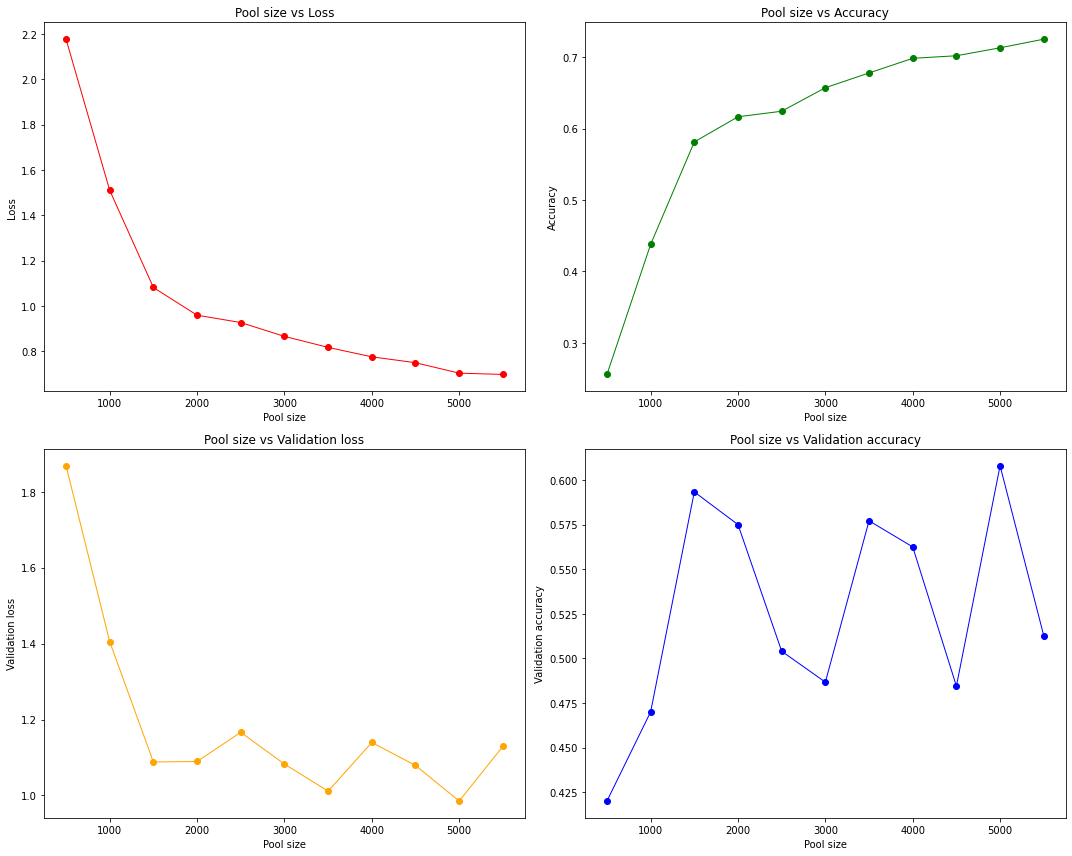

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax[0, 0].plot(pool_sizes, losses, linewidth=1.0, color='red', marker='o')
ax[0, 0].set(title=f'Pool size vs Loss', xlabel='Pool size', ylabel='Loss')

ax[0, 1].plot(pool_sizes, accuracies, linewidth=1.0, color='green', marker='o')
ax[0, 1].set(title=f'Pool size vs Accuracy', xlabel='Pool size', ylabel='Accuracy')

ax[1, 0].plot(pool_sizes, losses_val, linewidth=1.0, color='orange', marker='o')
ax[1, 0].set(title=f'Pool size vs Validation loss', xlabel='Pool size', ylabel='Validation loss')

ax[1, 1].plot(pool_sizes, accuracies_val, linewidth=1.0, color='blue', marker='o')
ax[1, 1].set(title=f'Pool size vs Validation accuracy', xlabel='Pool size', ylabel='Validation accuracy')

plt.tight_layout()
plt.show()

In [12]:
accuracy_ratio = (test_acc_al / test_acc_baseline) * 100
loss_ratio = (test_loss_al / test_loss_baseline) * 100
data_ratio = (X_pool.shape[0] / X_train_baseline.shape[0]) * 100

print(f"Accuracy difference: {accuracy_ratio}%")
print(f"Loss difference: {loss_ratio}%")
print(f"Dataset size difference: {data_ratio}%")

Accuracy difference: 93.85876743721971%
Loss difference: 157.928286432579%
Dataset size difference: 9.166666666666666%
